In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import os
import glob
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## Take chosen features for all basins with temporal aggregations with target Emiliani2 VHI

In [ ]:
csv_with_aggreg = "./features_with_aggregations.csv"
csv_target = "./csv/Emiliani2.csv"
classnames = ['Normal', 'Good', 'Bad']

In [ ]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [ ]:
# merge with target values of Emiliani2

target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [ ]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [ ]:
chosen_features_ids = [93, 68, 131, 110]
chosen_features_df = features_df.iloc[:,chosen_features_ids]

In [ ]:
idx_dic = {}
for col in chosen_features_df.columns:
    idx_dic[col] = chosen_features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Emiliani1_rr_4w
1: cyclostationary_mean_Lambro_Olona_tg_1w
2: cyclostationary_mean_Lambro_Olona_rr_12w
3: cyclostationary_mean_Oglio_Iseo_rr_1w


In [ ]:
# divide into train/val/test sets

train_perc = 0.6
valid_perc = 0.2
train_valid_perc = 1 - valid_perc

tot_rows = len(chosen_features_df)

features_train = chosen_features_df.iloc[0:round(tot_rows*train_perc)]
target_train = target_df.iloc[0:round(tot_rows*train_perc)]

scaler_f = StandardScaler()
scaler_t = StandardScaler()
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# created a new scaled dataframe applying the scaling to all the data
scaled_chosen_features_df = pd.DataFrame(scaler_f.transform(chosen_features_df[chosen_features_df.columns]), 
                                    index=chosen_features_df.index, columns=chosen_features_df.columns)
scaled_target_df = pd.DataFrame(scaler_t.transform(target_df[target_df.columns]), 
                                    index=target_df.index, columns=target_df.columns)

# update train/val/test sets
features_train = scaled_chosen_features_df.iloc[0:round(tot_rows*train_perc)]
features_validation = scaled_chosen_features_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
features_train_validation = pd.concat([features_train, features_validation])
features_test = scaled_chosen_features_df.iloc[round(tot_rows*train_valid_perc):]

target_train = scaled_target_df.iloc[0:round(tot_rows*train_perc)]
target_validation = scaled_target_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
target_test = scaled_target_df.iloc[round(tot_rows*train_valid_perc):]

In [ ]:
X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

## Compute and plot quantiles

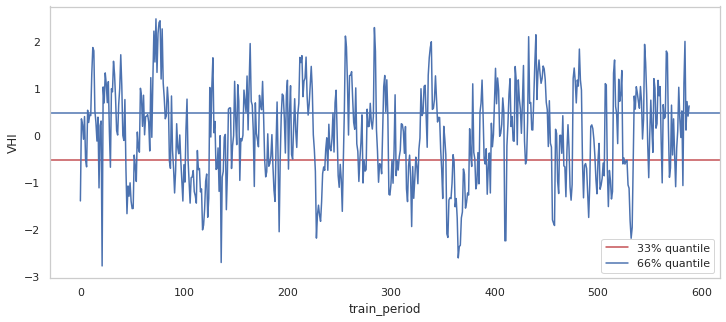

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})

y_min = target_train['mean'].quantile(0.33)
y_max = target_train['mean'].quantile(0.66)

plt.ylabel("VHI")
plt.xlabel("train_period")

plt.axhline(y_min, label='33% quantile', color = 'r')
plt.axhline(y_max, label='66% quantile')
plt.legend(loc="lower right")
plt.plot(target_train['mean'])

In [ ]:
# transform the target in three classes

target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
target_test['mean'] = target_test['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)

In [ ]:
np.unique(target_train['mean'], return_counts = True)

(array([-1,  0,  1]), array([195, 194, 200]))

In [ ]:
y_train = target_train.values
y_validation = target_validation.values
y_test = target_test.values
y_train_validation = pd.concat([target_train, target_validation]).values

In [ ]:
def plot_conmat(true, pred, title, ax, ffnn):
    if ffnn:
      conmat = confusion_matrix(true, pred, labels = [1, 0, 2])
    else:
      conmat = confusion_matrix(true, pred, labels = [1, 0, -1])
    val = np.mat(conmat)

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df_cm.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    plt.rcParams["figure.figsize"] = (5,5)
    if title is not None : ax.set_title(title) 

## Extra Trees Classifier

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
               }

In [ ]:
from sklearn.model_selection import GridSearchCV

ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(features_train_validation, y_train_validation)

In [ ]:
opt.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 45}

In [ ]:
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 45)

rfc.fit(X_train_validation, y_train_validation)

ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=45,
                     random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.622 
 MSE:  0.796 
 acc_test:  0.464 
 acc_train:  0.959


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(chosen_features_df.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_Emiliani1_rr_4w Importance: 0.29
Variable: cyclostationary_mean_Lambro_Olona_tg_1w Importance: 0.27
Variable: cyclostationary_mean_Lambro_Olona_rr_12w Importance: 0.26
Variable: cyclostationary_mean_Oglio_Iseo_rr_1w Importance: 0.18


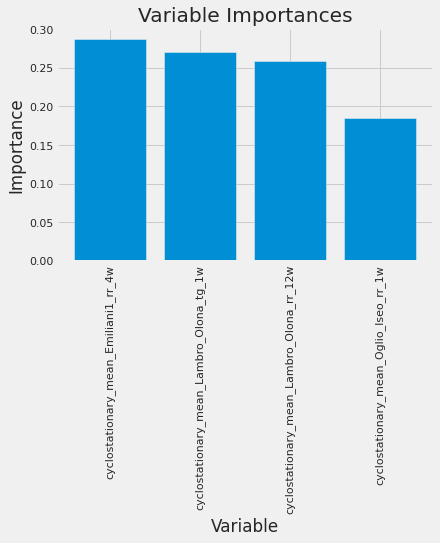

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

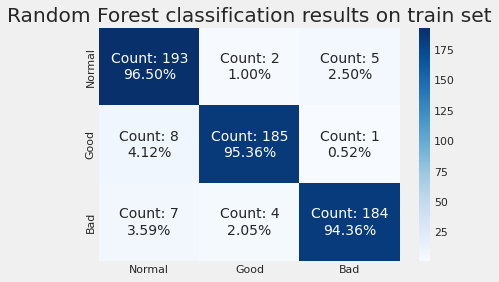

In [ ]:
fig,ax=plt.subplots()
plot_conmat(target_train, rfc.predict(features_train), 'Random Forest classification results on train set', ax=ax, ffnn = False)

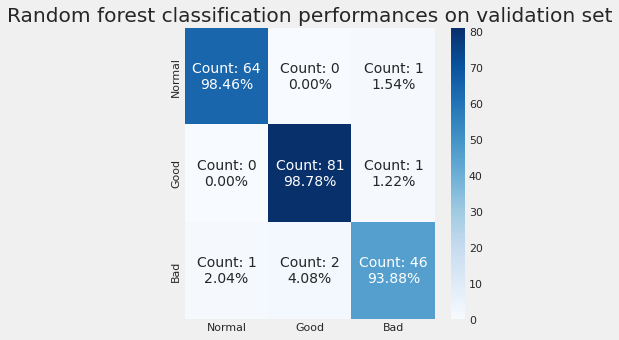

In [ ]:
fig,ax=plt.subplots()
plot_conmat(target_validation.values, rfc.predict(features_validation), 'Random forest classification performances on validation set', ax=ax, ffnn = False)

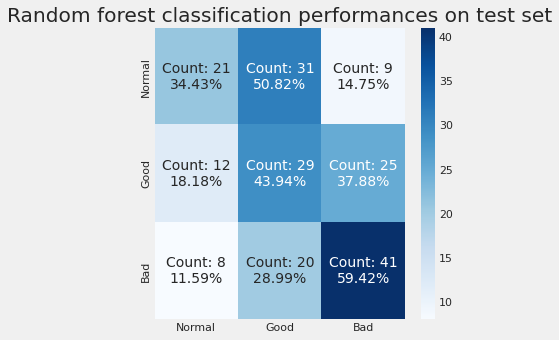

In [ ]:
fig, ax = plt.subplots()
plot_conmat(target_test, rfc.predict(features_test), 'Random forest classification performances on test set', ax=ax, ffnn = False)
plt.savefig('random_forest_classification_singletask.eps', format='eps')

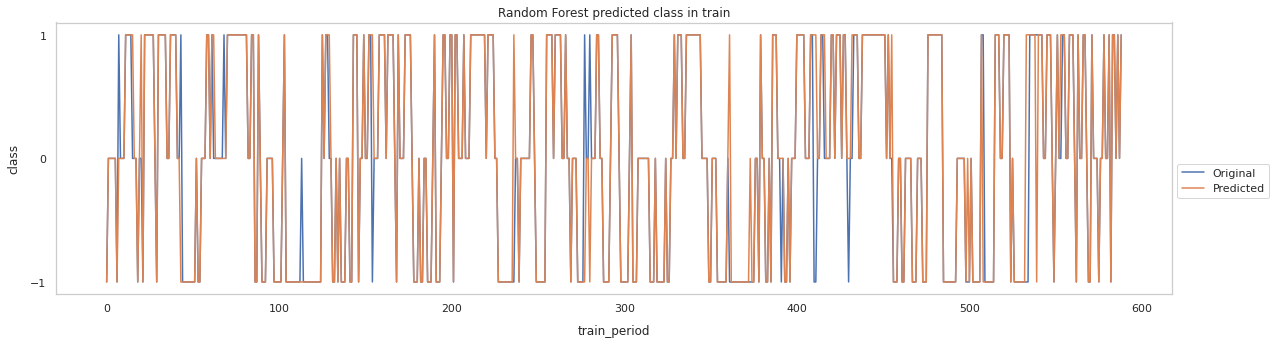

In [ ]:
fig, ax= plt.subplots()
plt.plot(y_train, label='Original')
plt.title('Random Forest predicted class in train')
plt.plot(rfc.predict(X_train), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

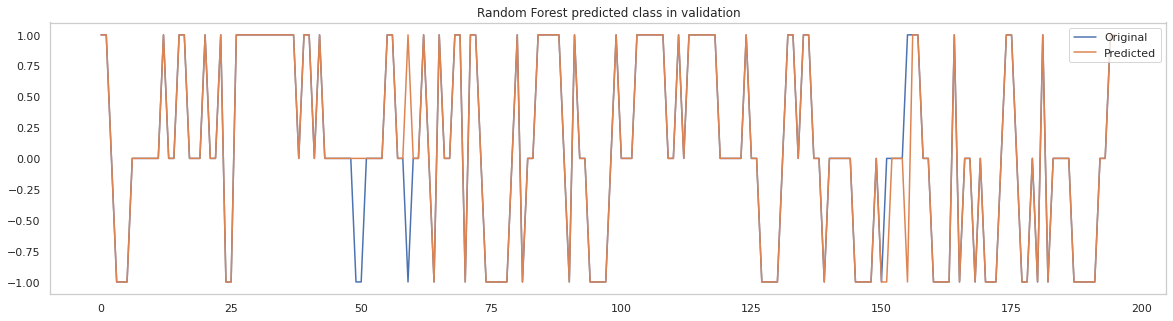

In [ ]:
plt.plot(y_validation, label='Original')
plt.title('Random Forest predicted class in validation')
plt.plot(rfc.predict(X_validation), label='Predicted')
plt.legend()
plt.show()

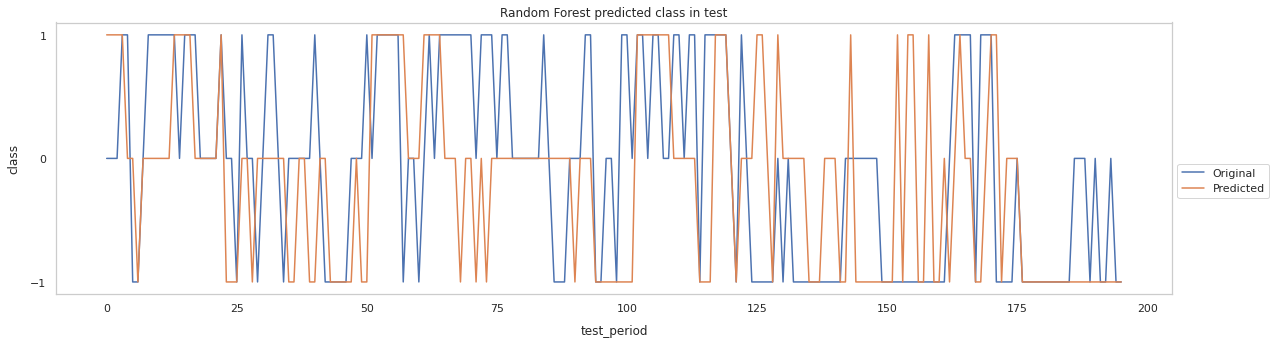

In [ ]:
fig, ax= plt.subplots()
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Random Forest predicted class in test')
plt.plot(rfc.predict(features_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Feed Forward

In [ ]:
def feed_forward():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(len(classnames), activation='softmax',name='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# 001 for -1, 100 for 0, 010 for 1
y_train = np.eye(3)[target_train['mean']]
y_validation = np.eye(3)[target_validation['mean']]
y_test = np.eye(3)[target_test['mean']]

In [ ]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train, validation_data = (X_validation, y_validation), shuffle=False, epochs=1000, verbose=0)

Text(0, 0.5, 'loss')

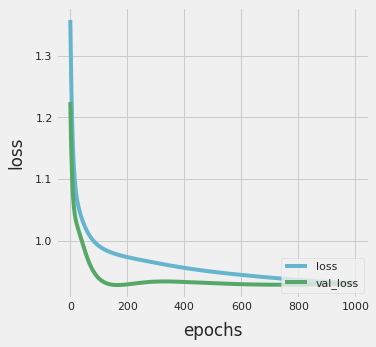

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")

plt.legend(loc="lower right")

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
y_train_val = np.concatenate((y_train, y_validation))

model = feed_forward()
tmp = model.fit(X_train_validation, y_train_val, shuffle=False, epochs=160, verbose=0)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 softmax (Dense)             (None, 3)                 15        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("FFNN:")
print("      ",model.metrics_names)
print("test: ", model.evaluate(X_test,y_test, verbose = 0))
print("train: ", model.evaluate(X_train_validation,y_train_val, verbose = 0))

FFNN:
       ['loss', 'accuracy']
test:  [1.0489566326141357, 0.4285714328289032]
train:  [0.9475980997085571, 0.522292971611023]


19/19 [==============================] - 0s 2ms/step


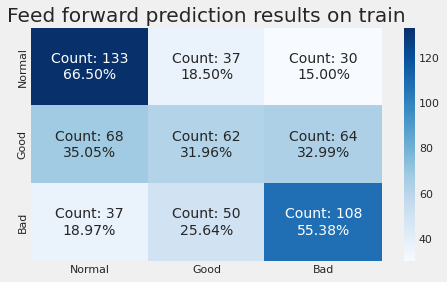

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_train.argmax(axis=1), model.predict(X_train).argmax(axis=1), 'Feed forward prediction results on train', ax=ax, ffnn = True)

7/7 [==============================] - 0s 2ms/step


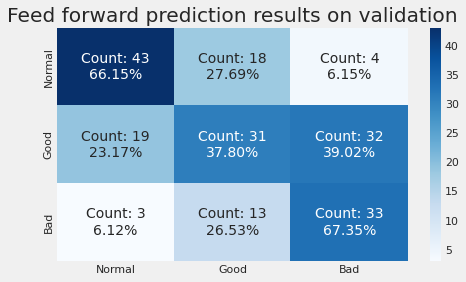

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_validation.argmax(axis=1), model.predict(X_validation).argmax(axis=1), 'Feed forward prediction results on validation', ax=ax, ffnn = True)

7/7 [==============================] - 0s 3ms/step


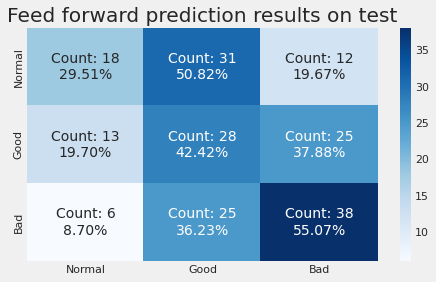

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
plot_conmat(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), 'Feed forward prediction results on test', ax=ax, ffnn = True)

In [ ]:
trues_test = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_test.argmax(axis=1)))
preds = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_test).argmax(axis=1)))

7/7 [==============================] - 0s 2ms/step


In [ ]:
import pickle 
with open('preds_st_ffnn.pickle', 'wb') as f: pickle.dump(preds,f)

19/19 [==============================] - 0s 2ms/step


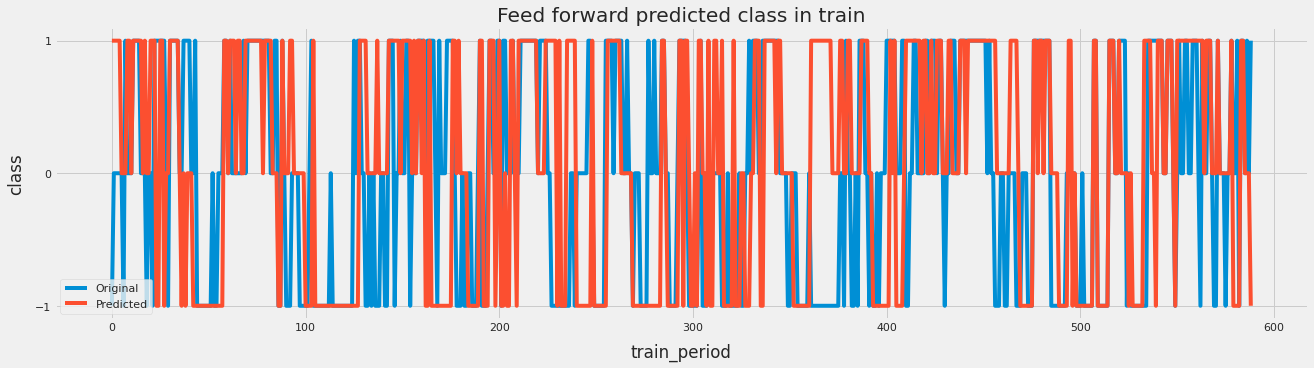

In [ ]:
fig, ax= plt.subplots()
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_train.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_train).argmax(axis=1))), label='Predicted')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.legend()
plt.show()

7/7 [==============================] - 0s 3ms/step


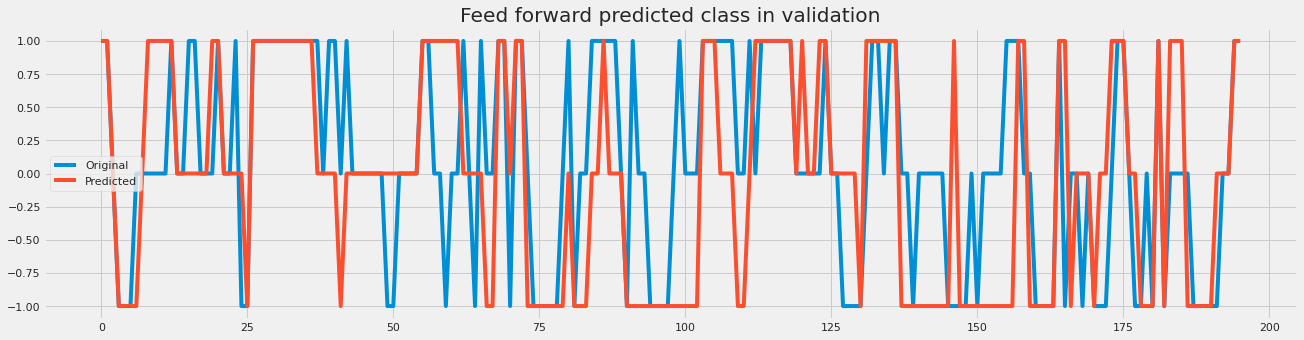

In [ ]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_validation.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in validation')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(features_validation).argmax(axis=1))), label='Predicted')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)

plt.legend()
plt.show()

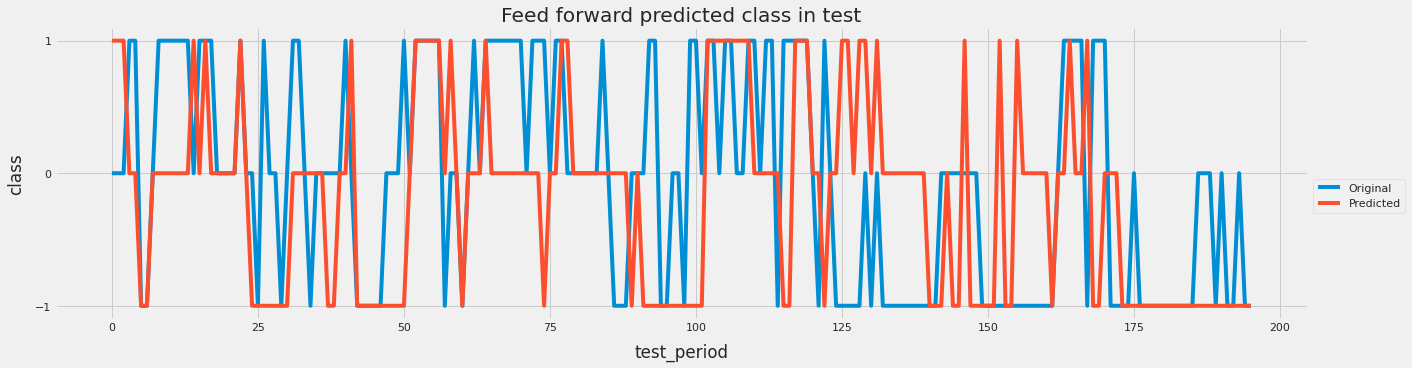

In [ ]:
fig, ax = plt.subplots()
plt.plot(trues_test, label='Original')
plt.title('Feed forward predicted class in test')
plt.plot(preds, label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.rcParams["figure.figsize"] = (20,5)
plt.show()